# Before

<img src="figs/profile_hot_spring.png" style="float: left; width: 50%; margin-right: 1%; margin-bottom: 0.5em;">

# After

In [1]:
allsites <- read.csv("YNP_PS.csv")

In [2]:
head(allsites)
summary(allsites)

File,Name,Sample,Year,Area,PS,pH,pH_cb,cb,Eh,...,Cs.,Ba.2,La.3,Hf.4,WO4.2,Tl.,Pb.2,Th.4,U.4,Hg.2
1,Spear's Latrine,080719N,2008,GOPA,Y,2.405,2.428,0.8153,0.9968,...,9.12e-08,9.01e-08,8.06e-07,1.68e-10,1.37e-08,4.65e-09,2.08e-09,1.98e-08,1.81e-08,0
2,Figure 8 Pool,080719P,2008,GOPA,N,3.158,3.104,-0.4650,0.9113,...,5.34e-07,1.42e-07,1.00e-08,4.26e-10,5.60e-07,5.09e-10,1.35e-09,1.17e-09,0.00e+00,0
3,Spotted Grizzly Pool,080719R,2008,GOPA,Y,3.234,3.251,0.2909,0.9423,...,2.23e-08,1.53e-06,6.26e-09,2.18e-10,1.52e-08,3.28e-10,3.04e-09,7.41e-10,3.78e-10,0
4,Dreamcicle,080719S,2008,GOPA,N,2.030,2.053,1.7531,0.9742,...,4.61e-08,6.42e-07,1.52e-06,3.03e-10,3.70e-09,2.59e-08,3.14e-07,2.11e-07,6.85e-08,0
5,Figure 8 Outflow 1,080719Z,2008,GOPA,,3.129,3.453,2.0190,0.9254,...,5.44e-07,1.50e-07,1.11e-08,0.00e+00,7.07e-07,5.38e-10,0.00e+00,1.22e-09,2.94e-10,0
6,Figure 8 Outflow 2,080719A,2008,GOPA,,3.123,3.058,-0.5496,0.9320,...,5.49e-07,1.51e-07,1.02e-08,0.00e+00,5.49e-07,5.68e-10,1.29e-09,1.07e-09,0.00e+00,0


      File                  Name          Sample          Year     
 Min.   :   1   Lobster Claw  :  11   60810  :   9   Min.   :2001  
 1st Qu.: 276   Roman Bath    :  10   60809  :   3   1st Qu.:2008  
 Median : 551   The Dryer     :  10   070711C:   2   Median :2010  
 Mean   : 551   Milk Chocolate:   8   010727L:   1   Mean   :2009  
 3rd Qu.: 826   Acid Pants    :   7   010727M:   1   3rd Qu.:2011  
 Max.   :1101   Bison Pool    :   7   010729P:   1   Max.   :2015  
                (Other)       :1048   (Other):1084                 
               Area     PS            pH             pH_cb          
 GOPA            :124    :261   Min.   : 0.797   Min.   :-999.0000  
 Sylvan          :105   M: 37   1st Qu.: 2.907   1st Qu.:   2.9890  
 Sentinel Meadow : 72   N:604   Median : 5.399   Median :   6.5170  
 Amphitheater    : 57   Y:199   Mean   : 5.746   Mean   :   0.6558  
 Sentinel Meadows: 55           3rd Qu.: 8.168   3rd Qu.:   8.4840  
 Sylvan Spring   : 51           Max.   :11

In [3]:
allsites[allsites == -999] <- NA
allsites[allsites == 0] <- NA

head(summary(allsites))
head(allsites)

      File                  Name          Sample          Year     
 Min.   :   1   Lobster Claw  :  11   60810  :   9   Min.   :2001  
 1st Qu.: 276   Roman Bath    :  10   60809  :   3   1st Qu.:2008  
 Median : 551   The Dryer     :  10   070711C:   2   Median :2010  
 Mean   : 551   Milk Chocolate:   8   010727L:   1   Mean   :2009  
 3rd Qu.: 826   Acid Pants    :   7   010727M:   1   3rd Qu.:2011  
 Max.   :1101   (Other)       :1054   010729P:   1   Max.   :2015  
               Area     PS            pH             pH_cb       
 GOPA            :124    :261   Min.   : 0.797   Min.   : 1.213  
 Sylvan          :105   M: 37   1st Qu.: 2.907   1st Qu.: 3.025  
 Sentinel Meadow : 72   N:604   Median : 5.399   Median : 6.535  
 Amphitheater    : 57   Y:199   Mean   : 5.746   Mean   : 6.133  
 Sentinel Meadows: 55           3rd Qu.: 8.168   3rd Qu.: 8.492  
 Sylvan Spring   : 51           Max.   :11.900   Max.   :12.329  
       cb                Eh               IS             Tempe

File,Name,Sample,Year,Area,PS,pH,pH_cb,cb,Eh,...,Cs.,Ba.2,La.3,Hf.4,WO4.2,Tl.,Pb.2,Th.4,U.4,Hg.2
1,Spear's Latrine,080719N,2008,GOPA,Y,2.405,2.428,0.8153,0.9968,...,9.12e-08,9.01e-08,8.06e-07,1.68e-10,1.37e-08,4.65e-09,2.08e-09,1.98e-08,1.81e-08,NA
2,Figure 8 Pool,080719P,2008,GOPA,N,3.158,3.104,-0.4650,0.9113,...,5.34e-07,1.42e-07,1.00e-08,4.26e-10,5.60e-07,5.09e-10,1.35e-09,1.17e-09,NA,NA
3,Spotted Grizzly Pool,080719R,2008,GOPA,Y,3.234,3.251,0.2909,0.9423,...,2.23e-08,1.53e-06,6.26e-09,2.18e-10,1.52e-08,3.28e-10,3.04e-09,7.41e-10,3.78e-10,NA
4,Dreamcicle,080719S,2008,GOPA,N,2.030,2.053,1.7531,0.9742,...,4.61e-08,6.42e-07,1.52e-06,3.03e-10,3.70e-09,2.59e-08,3.14e-07,2.11e-07,6.85e-08,NA
5,Figure 8 Outflow 1,080719Z,2008,GOPA,,3.129,3.453,2.0190,0.9254,...,5.44e-07,1.50e-07,1.11e-08,NA,7.07e-07,5.38e-10,NA,1.22e-09,2.94e-10,NA
6,Figure 8 Outflow 2,080719A,2008,GOPA,,3.123,3.058,-0.5496,0.9320,...,5.49e-07,1.51e-07,1.02e-08,NA,5.49e-07,5.68e-10,1.29e-09,1.07e-09,NA,NA


In [4]:
allsites$Eh[is.na(allsites$O2) == TRUE] <- NA
head(summary(allsites))

      File                  Name          Sample          Year     
 Min.   :   1   Lobster Claw  :  11   60810  :   9   Min.   :2001  
 1st Qu.: 276   Roman Bath    :  10   60809  :   3   1st Qu.:2008  
 Median : 551   The Dryer     :  10   070711C:   2   Median :2010  
 Mean   : 551   Milk Chocolate:   8   010727L:   1   Mean   :2009  
 3rd Qu.: 826   Acid Pants    :   7   010727M:   1   3rd Qu.:2011  
 Max.   :1101   (Other)       :1054   010729P:   1   Max.   :2015  
               Area     PS            pH             pH_cb       
 GOPA            :124    :261   Min.   : 0.797   Min.   : 1.213  
 Sylvan          :105   M: 37   1st Qu.: 2.907   1st Qu.: 3.025  
 Sentinel Meadow : 72   N:604   Median : 5.399   Median : 6.535  
 Amphitheater    : 57   Y:199   Mean   : 5.746   Mean   : 6.133  
 Sentinel Meadows: 55           3rd Qu.: 8.168   3rd Qu.: 8.492  
 Sylvan Spring   : 51           Max.   :11.900   Max.   :12.329  
       cb                Eh               IS             Tempe

In [5]:
allsites$Year <- as.factor(allsites$Year)
head(summary(allsites))

      File                  Name          Sample          Year    
 Min.   :   1   Lobster Claw  :  11   60810  :   9   2010   :202  
 1st Qu.: 276   Roman Bath    :  10   60809  :   3   2011   :185  
 Median : 551   The Dryer     :  10   070711C:   2   2012   :180  
 Mean   : 551   Milk Chocolate:   8   010727L:   1   2009   :170  
 3rd Qu.: 826   Acid Pants    :   7   010727M:   1   2006   : 72  
 Max.   :1101   (Other)       :1054   010729P:   1   2005   : 60  
               Area     PS            pH             pH_cb       
 GOPA            :124    :261   Min.   : 0.797   Min.   : 1.213  
 Sylvan          :105   M: 37   1st Qu.: 2.907   1st Qu.: 3.025  
 Sentinel Meadow : 72   N:604   Median : 5.399   Median : 6.535  
 Amphitheater    : 57   Y:199   Mean   : 5.746   Mean   : 6.133  
 Sentinel Meadows: 55           3rd Qu.: 8.168   3rd Qu.: 8.492  
 Sylvan Spring   : 51           Max.   :11.900   Max.   :12.329  
       cb                Eh               IS             Temperature 

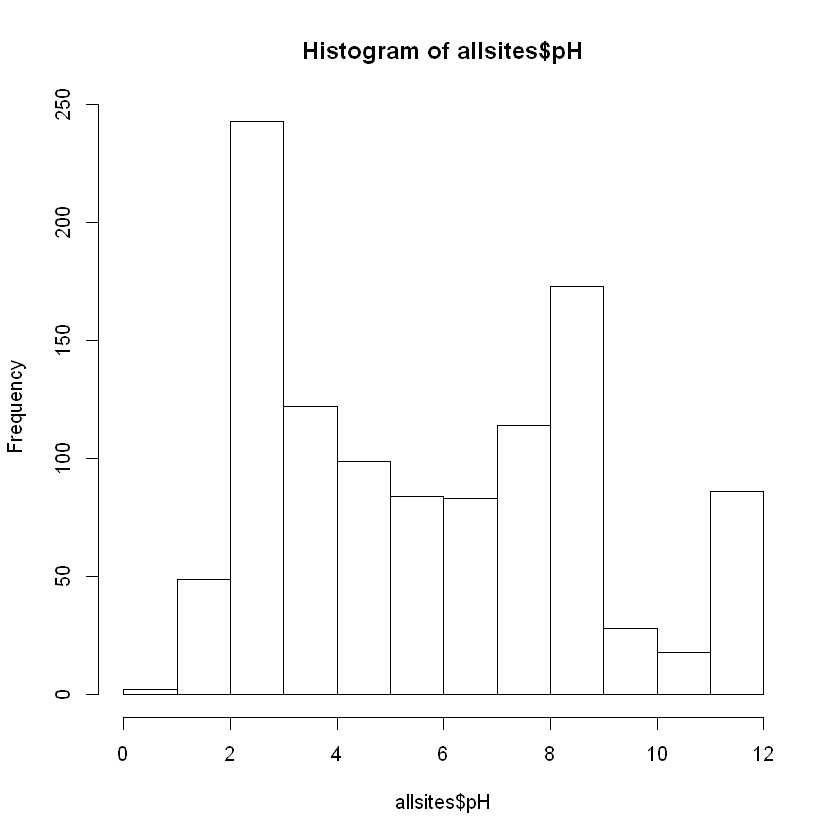

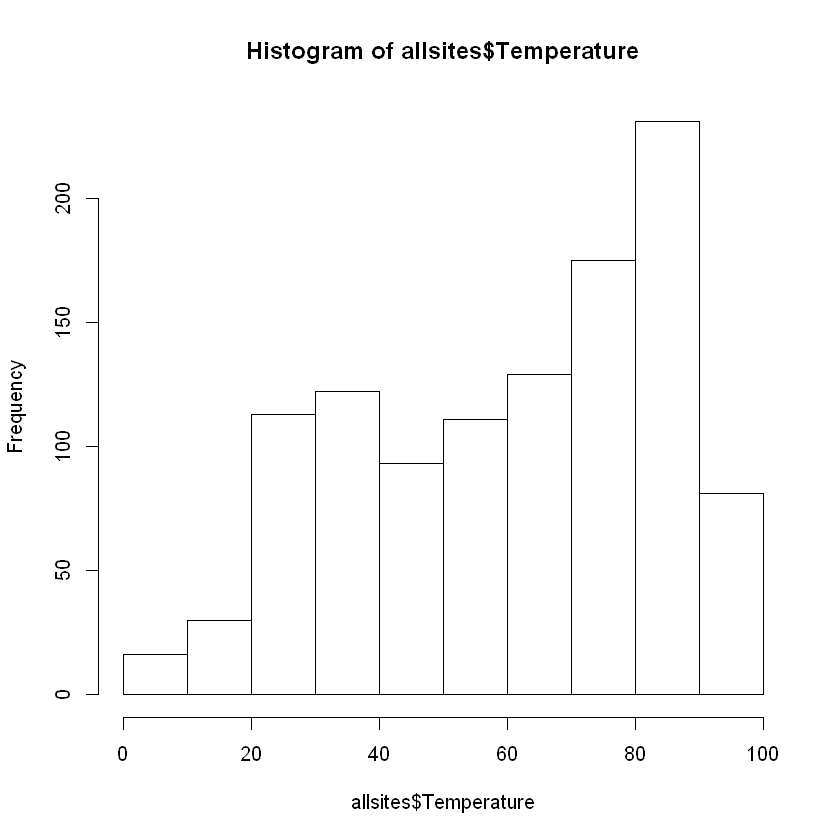

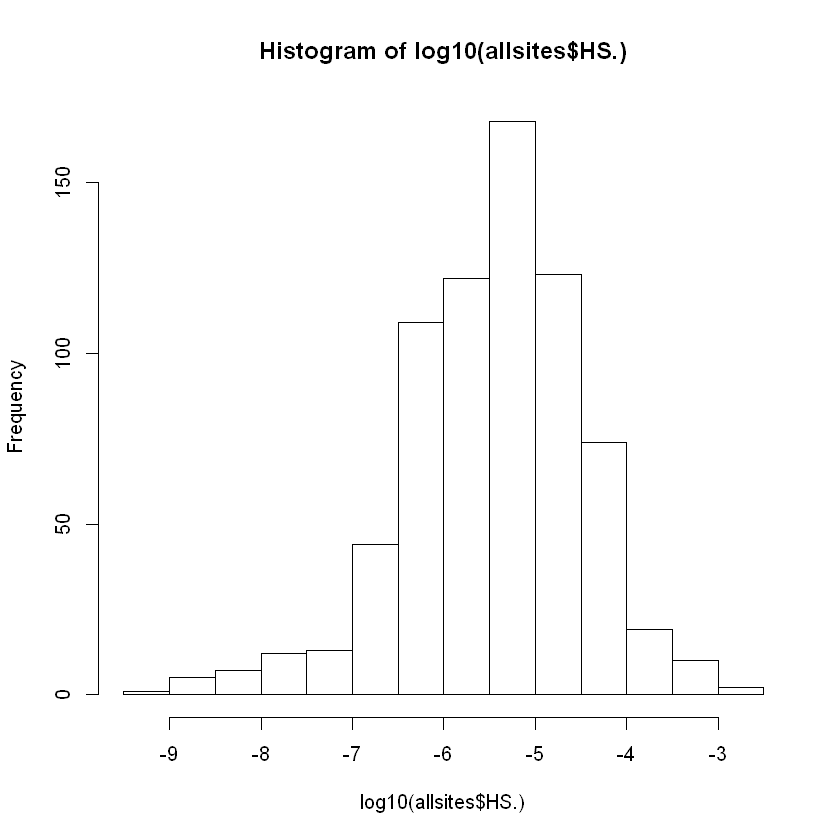

In [6]:
hist(allsites$pH)
hist(allsites$Temperature)
hist(log10(allsites$HS.))

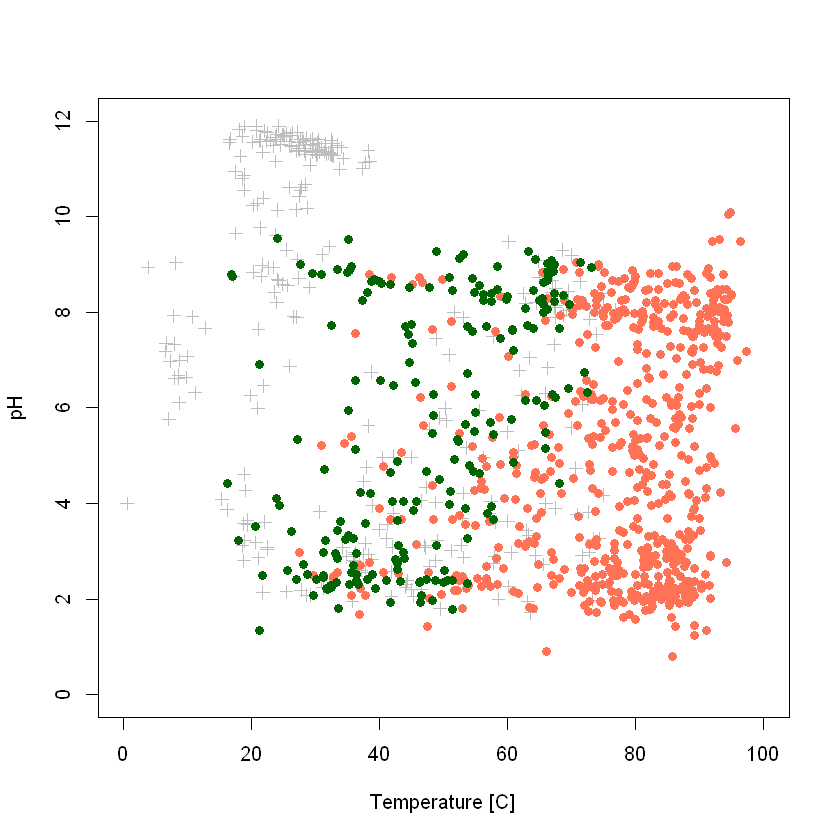

In [7]:
Ysites <- allsites[allsites$PS == "Y",]
Nsites <- allsites[allsites$PS == "N",]
Msites <- allsites[allsites$PS != "Y" & allsites$PS != "N",]

plot(Msites$Temperature, Msites$pH, ylim = c(0, 12), xlim = c(0, 100), ylab = "pH", xlab = "Temperature [C]", pch = 3, col = "gray")
points(Nsites$Temperature, Nsites$pH, pch = 19, col = "coral1")
points(Ysites$Temperature, Ysites$pH, pch = 19, col = "darkgreen")

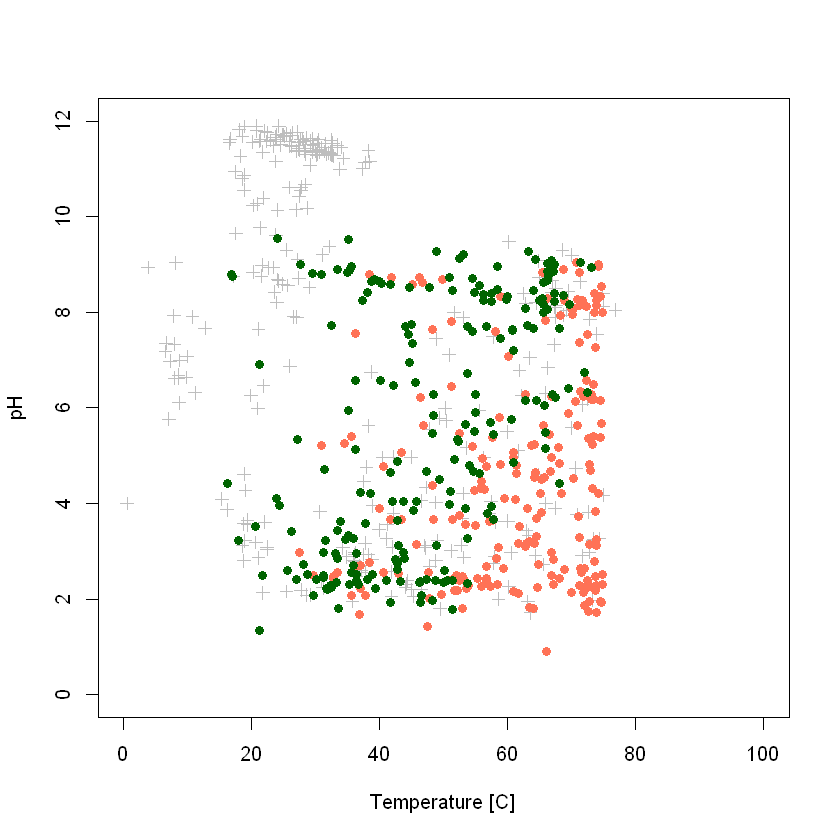

In [8]:
N75sites <- allsites[allsites$PS == "N" & allsites$Temperature < 75,]
plot(Msites$Temperature, Msites$pH, ylim = c(0, 12), xlim = c(0, 100), ylab = "pH", xlab = "Temperature [C]", pch = 3, col = "gray")
points(N75sites$Temperature, N75sites$pH, pch = 19, col = "coral1")
points(Ysites$Temperature, Ysites$pH, pch = 19, col = "darkgreen")

In [9]:
# Create our Yes/No-only training set
train <- rbind(Ysites, Nsites)

# Summarize. Notice that levels other than "Y" and "N" are still showing up for PS.
head(summary(train))

      File                       Name         Sample         Year    
 Min.   :   1.0   Lobster Claw     : 11   070711C:  2   2010   :153  
 1st Qu.: 250.5   Roman Bath       : 10   60809  :  2   2011   :141  
 Median : 467.0   Milk Chocolate   :  8   010727L:  1   2012   :139  
 Mean   : 478.2   Acid Pants       :  7   010727M:  1   2009   :126  
 3rd Qu.: 707.5   Sylvan Spring    :  7   010729P:  1   2007   : 56  
 Max.   :1083.0   Goldilocks Source:  6   010729S:  1   2006   : 52  
                  Area     PS            pH             pH_cb       
 GOPA               : 97    :  0   Min.   : 0.797   Min.   : 1.213  
 Sylvan             : 95   M:  0   1st Qu.: 2.657   1st Qu.: 2.698  
 Sentinel Meadow    : 69   N:604   Median : 4.848   Median : 5.995  
 Sentinel Meadows   : 49   Y:199   Mean   : 5.142   Mean   : 5.599  
 Norris Geyser Basin: 43           3rd Qu.: 7.718   3rd Qu.: 8.129  
 Amphitheater       : 41           Max.   :10.097   Max.   :11.272  
       cb                Eh

In [10]:
# Let's drop unused levels:
train$PS <- droplevels(train$PS)

# Only levels Y and N are present
summary(train$PS)

N   Y 
604 199

In [11]:
n <- nrow(train)
n

[1] 803

In [12]:
ntrain <- round(n*0.8)
ntrain

[1] 642

In [13]:
set.seed(654321)
tindex <- sample(n, ntrain)
tindex

[1]  80 409 738 219 510 776 511 314 205 230 759 671 295 604 399 518 471 561
 [19] 463 534 651 204 771 522 488 642 605 321  81 532 489 578 591 505 347 720
 [37] 770 717 308 553 413 366 780 461 537 594 164 672 304 403 146 685 339  42
 [55] 649  49 664 525  41 644 676 526 330 493 616 356 790 434 372 407 733  52
 [73] 206 300 545 332 517 725 210 484 298 353 730 229  95 159 758 586 112 139
 [91] 481 438 214 607 394 765 453 736 361  18 433  44 296 800 620  45 351  14
[109]   7 789 535 395 416 608 523 661   2 278  66 689  72 788 426 480 731 495
[127]  60 786  51 363 151 487 600  35 412 476 502 196  20 148 512 551 160 792
[145] 176 572  78 569 473 669  40 154 350 630 223 632 192 233 714 271 482 193
[163]  21 621 590 177 245 802  65  88 795 501 390 546  43 269 634 410 602 191
[181] 107 718 763 415  28  84 576   9 228  77 739 338  90 352 294 185 503 692
[199] 490 400 446 571 285 279 306 653 121 784 297 123  74 441 227 764  83 687
[217] 782 324 585 421 659 124 178 762 117  64 497 103 724  16 357 358 188  54
[235]  59 592 262 365 555 319 364 626 528 598 623 475 127 243 442 631 466 743
[253] 799 541 622  32  19 182 641 256 695  50 706 584 753  79  38 509 628 670
[271]   1 444  11 774 126 556 516 138 346  15 379 325 575 702 454  87  27 157
[289] 557 180 697 727 288 667 468 322 506 341 397 593 266 303 750 354 514 700
[307] 109 320 698 345 440 452 118 803  73  12 224 402 423 327  70 647 249 701
[325] 104 570 715 662 614 301 521 253 699 261   6 688 221 232 432 673 675 240
[343] 654 246 611  25 235 302 637  36 212 336 574 558 396 108 183  46 406 331
[361] 732  58  94 726 684 315 284 754 559 722 186 149 716 624 633  24 307  96
[379] 391 376 515 683 640 459 465 744 721 381 137 588 384 116 519 436 573 316
[397] 281 617 437 171 299 496 258 323 405  29 359 367 197 533 130 378 710 181
[415] 198 707 513 767 250 768 791 340  61 280 115 680 603  75   3 387 752 618
[433] 428  17 218 756 411 755 693 524 179 105 273 293  86 369 745 462  67 166
[451] 613 435 174 239 282 639 371 202 277 417 769 100 337 207 165 691 276 451
[469] 385 499 255 458  98 470 708 507 562 380 430  62 777 275  31 652 252 741
[487] 766 102 161 548 248 627  53 386 305 796  55 682 635 711   4 251 696 712
[505] 189  57 460 625 540 209 286 129 419 520  39 797 779 477 225 606  69 686
[523] 144 772 290 195 401 431 747 485 793 554 577 794 392 508 615 200 158 679
[541] 658 587 377 737 645 292 773 335 226 599 787 486 382 389 134  13 491 150
[559] 719 723 565 155 374 257  99 270 328 751   8 657 190 247 388  30 145  85
[577] 704 310 373 778 135 355 563 414 238 660  76 472 326 678 500 344 610 260
[595] 272  68 167 131 646 531 746 234 236 309 529 597 128 216 474 560 187 705
[613] 536 122 504 343 111 713 478 169 439 456 168 494 141 567 429 333 582 492
[631] 106 263 199  97 609  89 313 690 579 133 449 595

In [14]:
xtrain <- train[tindex,]
xtest <- train[-tindex,]

head(xtrain)
head(xtest)

,File,Name,Sample,Year,Area,PS,pH,pH_cb,cb,Eh,...,Cs.,Ba.2,La.3,Hf.4,WO4.2,Tl.,Pb.2,Th.4,U.4,Hg.2
318,318,Blondie Zygo Mat,120721TZ,2012,Sylvan,Y,2.520,2.275,-11.5684,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
357,357,Fudge Factory,090725CA,2009,GOPA,N,4.408,4.479,0.1317,0.8824,...,2.41e-07,3.57e-07,1.87e-09,1.01e-10,3.75e-07,7.34e-10,5.21e-10,4.91e-10,2.77e-10,NA
831,831,MLS Outflow 1 OFF,100729I1,2010,Imperial Geyser Basin,N,8.635,8.471,-1.5689,NA,...,1.20e-06,4.88e-09,2.16e-11,5.04e-11,2.16e-06,7.34e-10,1.01e-10,7.76e-11,1.13e-10,NA
29,29,Hell's Gate,080729A,2008,Rabbit South,N,3.960,3.941,-0.2270,0.9123,...,2.64e-08,1.52e-07,1.56e-09,NA,1.14e-10,1.86e-09,2.47e-09,1.25e-09,3.23e-09,NA
490,490,Devil's Ani Hot,010729T,2001,Sylvan,N,2.300,2.192,-12.3827,1.0223,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
903,903,Spitting Croisant,100804UA,2010,Geyser Creek Field Blank,N,4.930,9.514,14.9348,NA,...,1.69e-06,2.33e-08,1.73e-09,6.72e-11,1.49e-07,2.74e-10,2.32e-09,1.47e-10,3.70e-10,NA


,File,Name,Sample,Year,Area,PS,pH,pH_cb,cb,Eh,...,Cs.,Ba.2,La.3,Hf.4,WO4.2,Tl.,Pb.2,Th.4,U.4,Hg.2
35,35,Sex on the Beach,110708C,2011,Rabbit Creek North,Y,3.943,5.211,14.0260,0.9449,...,3.84e-07,1.09e-07,7.92e-11,2.41e-10,7.07e-10,5.38e-10,4.54e-10,4.31e-12,4.29e-10,NA
51,51,Allagash,110710B,2011,Rabbit Creek South,Y,4.670,6.199,31.0835,0.9019,...,4.44e-08,1.60e-07,1.22e-09,7.28e-11,1.52e-09,5.04e-10,5.26e-10,3.45e-11,1.05e-09,NA
115,115,Fuzzy Bacon,110718M,2011,Amphitheater,Y,4.640,7.744,4.7809,0.9144,...,1.36e-07,2.85e-07,5.83e-10,3.92e-10,1.08e-08,2.10e-10,1.11e-10,3.45e-11,1.26e-11,NA
117,117,Orange Dream Slush,110718O,2011,Amphitheater,Y,5.944,7.637,3.3387,0.8488,...,1.38e-07,2.50e-07,3.31e-10,5.60e-12,8.24e-09,5.14e-10,4.83e-11,4.31e-12,1.26e-11,NA
134,134,Mr. Toad,110720D1,2011,Rabbit Creek South,Y,4.233,5.743,23.1236,0.9447,...,1.50e-08,1.12e-07,1.66e-09,8.96e-11,5.66e-09,3.38e-10,5.89e-10,3.15e-10,5.97e-10,NA
193,193,Sherbert Bowl,120721SC,2012,Amphitheater,Y,6.950,7.378,2.8436,0.7628,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [15]:
# install.packages("party", repos="http://cran.us.r-project.org")
library(party)

Warning message:
"package 'party' was built under R version 3.3.3"Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Warning message:
"package 'strucchange' was built under R version 3.3.3"Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: sandwich
Warning message:
"package 'sandwich' was built under R version 3.3.3"

In [16]:
Photo_model <- ctree(formula = PS ~ pH + Temperature, data = xtrain)

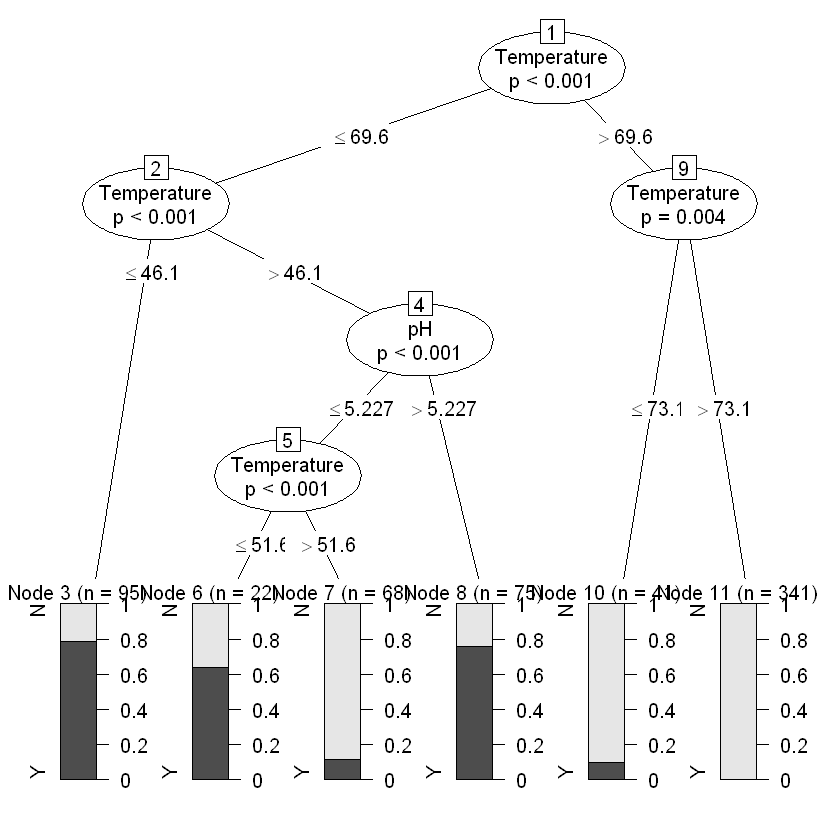

In [17]:
plot(Photo_model)

In [18]:
Photo_pred <- predict(object = Photo_model, newdata = xtest)
length(Photo_pred)
length(xtest$PS)
Photo_pred
xtest$PS

[1] 161

[1] 161

[1] N N Y Y Y Y Y Y Y Y N Y Y Y Y Y N Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y
 [38] Y Y Y Y N N N N N N N N N N Y N N N N N Y N N N Y N N N N Y N N Y Y N N Y
 [75] N N N N N N N N N Y Y N Y N N N N N N N N N N N N N N N N N N N N N N N N
[112] N N N N N N N N N N Y N N N N N N N N N N N N N N N N N N N N N N Y Y N Y
[149] N N N N Y N N N N N N N N
Levels: N Y

[1] Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y
 [38] Y Y Y Y N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N
 [75] N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N
[112] N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N
[149] N N N N N N N N N N N N N
Levels: N Y

In [19]:
# install.packages("caret", repos="http://cran.us.r-project.org")
# install.packages("e1071", repos="http://cran.us.r-project.org")
library(caret)

Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.3.3"

In [20]:
# test our model on the 20% remaining data
confusionMatrix(data = Photo_pred, reference = xtest$PS)

Confusion Matrix and Statistics

          Reference
Prediction   N   Y
         N 105   4
         Y  15  37
                                          
               Accuracy : 0.882           
                 95% CI : (0.8219, 0.9274)
    No Information Rate : 0.7453          
    P-Value [Acc > NIR] : 1.435e-05       
                                          
                  Kappa : 0.7144          
 Mcnemar's Test P-Value : 0.02178         
                                          
            Sensitivity : 0.8750          
            Specificity : 0.9024          
         Pos Pred Value : 0.9633          
         Neg Pred Value : 0.7115          
             Prevalence : 0.7453          
         Detection Rate : 0.6522          
   Detection Prevalence : 0.6770          
      Balanced Accuracy : 0.8887          
                                          
       'Positive' Class : N               
                                          

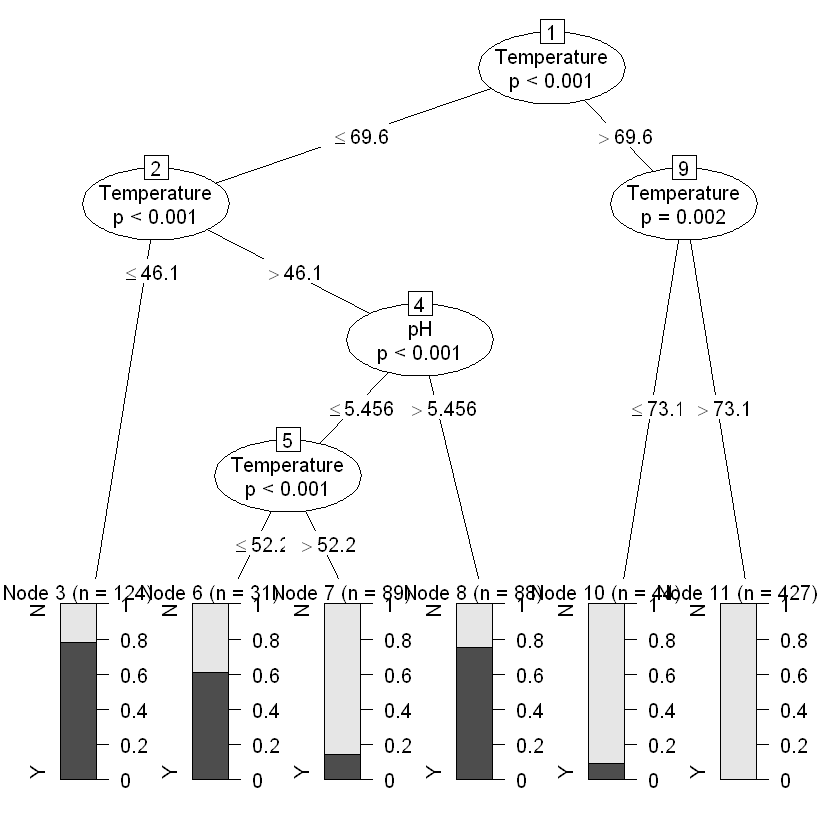

In [21]:
Photo_model <- ctree(formula = PS ~ pH + Temperature, data = train)
plot(Photo_model)


In [22]:
Photo_pred <- predict(object = Photo_model, newdata = allsites)
Photo_pred

[1] Y N Y N N Y Y Y N Y Y N N N N N N N N N N N N N N N N N N N N N N N N N Y
  [38] Y Y N Y N Y N N N N N Y N N N Y N N N N N N Y N N N N N Y N N Y N Y N Y Y
  [75] Y N Y N N N N N N Y N N N N Y N N Y Y N Y Y N N Y Y Y N N N Y N N Y Y Y N
 [112] N N N Y Y Y Y N Y Y Y Y N N N N N N N N N N Y N N Y N Y Y Y N N N N N N Y
 [149] N N N N N Y N Y N Y Y N Y N N N N N N Y Y N Y N N N Y N N Y N Y N Y N N N
 [186] Y N N N Y N N Y Y Y Y Y Y Y Y Y Y Y Y Y N N N Y Y Y Y Y N N N Y N Y Y Y Y
 [223] N N Y Y N N N N N Y Y N Y Y Y N N N N N Y Y Y Y Y Y N N N N Y Y Y N N N N
 [260] Y N N N Y Y N Y N N Y N Y N N N N Y Y N N N N N Y N N Y Y N Y Y Y N N Y Y
 [297] N N N Y Y N N N N N N Y Y N N N Y Y N N Y Y Y N N N Y N N N N N N N Y N N
 [334] N Y Y Y Y N Y N N Y N N Y N Y N Y N N Y N Y Y N N N Y Y Y N N Y N N N Y N
 [371] N N Y N N Y N N N Y N N N Y N N N Y N Y N N N N N Y N N Y N N Y N N N N N
 [408] N N Y N N N N N N N Y N Y N N N Y Y Y N N N N Y N N N N N N N N N N N Y Y
 [445] N N N N N N Y N N N N N N N N N N Y N N Y Y N N N N N N Y N Y N N N N N N
 [482] N N N N N N N N N N N N Y N N N N N N Y N N N Y N N Y Y N N N N N Y Y Y N
 [519] Y N N Y N Y N N N N N N N N N Y N N Y N N N N N Y Y Y Y N N N N N N N N N
 [556] Y N N Y N Y Y N N Y Y Y Y N N N N N N N Y N N N N Y N N N Y N Y Y N N Y N
 [593] N N Y Y Y Y N N N N Y Y Y Y Y Y Y N N N N N N N Y N N N Y Y N Y N Y N N N
 [630] N N Y N N N N N N Y N N N N N N N N N N N N N Y N N N N N Y N Y N N N N Y
 [667] N N N Y N N Y Y Y Y N N N Y N N N Y Y N Y Y N N N N Y Y Y N N N N N N N N
 [704] N N Y N N N N N N Y N N N Y Y Y N N Y Y N N N N N N N N Y N N N Y Y Y Y N
 [741] N Y N Y Y Y Y N Y N N Y N Y N N Y N N N Y Y N Y Y N N N Y Y Y Y Y N N Y N
 [778] N N N N Y N N N N Y Y Y N N N N N Y Y Y N N N N N N N Y N Y N N Y Y Y Y Y
 [815] Y Y N N N N Y Y Y Y Y Y N Y N N Y N Y Y Y Y Y Y Y N Y N N Y Y Y Y N Y N N
 [852] Y Y Y Y N N Y N N N N Y N Y N N Y Y Y Y N N N N Y N Y N N N N N Y Y Y N Y
 [889] Y Y N Y N N N Y Y Y Y N N N N N N N N N Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y
 [926] Y N N Y N N Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y
 [963] Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y
[1000] Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y
[1037] Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y N N N N Y Y Y N N N N N N N N N Y
[1074] N N N Y N N Y N N N Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y
Levels: N Y

In [23]:
allsites$PredPS <- Photo_pred
allsites

File,Name,Sample,Year,Area,PS,pH,pH_cb,cb,Eh,...,Ba.2,La.3,Hf.4,WO4.2,Tl.,Pb.2,Th.4,U.4,Hg.2,PredPS
1,Spear's Latrine,080719N,2008,GOPA,Y,2.405,2.428,0.8153,NA,...,9.01e-08,8.06e-07,1.68e-10,1.37e-08,4.65e-09,2.08e-09,1.98e-08,1.81e-08,NA,Y
2,Figure 8 Pool,080719P,2008,GOPA,N,3.158,3.104,-0.4650,NA,...,1.42e-07,1.00e-08,4.26e-10,5.60e-07,5.09e-10,1.35e-09,1.17e-09,NA,NA,N
3,Spotted Grizzly Pool,080719R,2008,GOPA,Y,3.234,3.251,0.2909,NA,...,1.53e-06,6.26e-09,2.18e-10,1.52e-08,3.28e-10,3.04e-09,7.41e-10,3.78e-10,NA,Y
4,Dreamcicle,080719S,2008,GOPA,N,2.030,2.053,1.7531,NA,...,6.42e-07,1.52e-06,3.03e-10,3.70e-09,2.59e-08,3.14e-07,2.11e-07,6.85e-08,NA,N
5,Figure 8 Outflow 1,080719Z,2008,GOPA,,3.129,3.453,2.0190,NA,...,1.50e-07,1.11e-08,NA,7.07e-07,5.38e-10,NA,1.22e-09,2.94e-10,NA,N
6,Figure 8 Outflow 2,080719A,2008,GOPA,,3.123,3.058,-0.5496,NA,...,1.51e-07,1.02e-08,NA,5.49e-07,5.68e-10,1.29e-09,1.07e-09,NA,NA,Y
7,Figure 8 Outflow 3,080719B,2008,GOPA,,3.090,2.968,-1.1074,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,Y
8,Witch's Brew,080730Z,2008,GOPA,N,2.080,3.409,25.0514,NA,...,7.43e-07,1.71e-06,6.16e-10,9.79e-08,3.82e-09,1.64e-08,8.15e-09,2.31e-09,NA,Y
9,Goldilocks Source,080721W,2008,Sylvan,N,2.469,2.362,-5.0668,NA,...,2.80e-07,1.49e-07,NA,1.10e-08,1.19e-09,1.15e-08,2.32e-08,3.74e-09,NA,N
10,Goldilocks Outflow 2.3m,080721Z,2008,Sylvan,Y,2.391,2.359,-1.6197,NA,...,3.15e-07,1.31e-07,NA,1.26e-08,1.08e-09,1.10e-08,2.07e-08,3.36e-09,NA,Y


In [30]:
Photo_model <- ctree(formula = PS ~ pH + Temperature + IS., data = xtrain)
plot(Photo_model)

ERROR: Error in eval(expr, envir, enclos): object 'IS.' not found


In [25]:
Photo_pred <- predict(object = Photo_model, newdata = xtest)
# test our model on the 20% remaining data
confusionMatrix(data = Photo_pred, reference = xtest$PS)

Confusion Matrix and Statistics

          Reference
Prediction   N   Y
         N 105   6
         Y  15  35
                                          
               Accuracy : 0.8696          
                 95% CI : (0.8076, 0.9174)
    No Information Rate : 0.7453          
    P-Value [Acc > NIR] : 8.594e-05       
                                          
                  Kappa : 0.6796          
 Mcnemar's Test P-Value : 0.08086         
                                          
            Sensitivity : 0.8750          
            Specificity : 0.8537          
         Pos Pred Value : 0.9459          
         Neg Pred Value : 0.7000          
             Prevalence : 0.7453          
         Detection Rate : 0.6522          
   Detection Prevalence : 0.6894          
      Balanced Accuracy : 0.8643          
                                          
       'Positive' Class : N               
                                          